# Hyytiälä 2018 figures for pyAPES 1.0 manuscript

## Load environmental variablesa and set pyAPES into path

In [1]:
import sys
import os
from dotenv import load_dotenv

load_dotenv()
pyAPES_main_folder = os.getenv('pyAPES_main_folder')
hyytiala_forcing = os.getenv('HYYTIALA_FORCING')
lad_data = os.getenv('HYYTIALA_LAD_PROFILES')
hyytiala_data_folder = os.getenv('HYYTIALA_2018_DATA')

sys.path.append(pyAPES_main_folder)

## Imports

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import re

from sklearn.metrics import r2_score

from pyAPES.utils.iotools import read_data
from pyAPES_utilities.timeseries_tools import diurnal_cycle

In [3]:
sns.set_context('paper', font_scale=1.5)

## Load Hyytiälä 2018 simulation data

To produce simdata run Demo_hyytiala_2018.ipynb

In [4]:
simdata = xr.open_dataset('../../results/FiHy2018.nc')

## Load Hyytiälä 2018 Eddy covariance data

In [5]:
# read EC fluxdata
flxdata = read_data(fr'{hyytiala_data_folder}/FIHy_flx_2018.dat', sep=';',
                    start_time=simdata.date[0].values, end_time=simdata.date[-1].values)

In [6]:
flxdata.columns

Index(['year', 'month', 'day', 'hour', 'minute', 'doy', 'NEE', 'GPP', 'Reco',
       'H', 'Gflux', 'Rnet', 'Qc_NEE', 'Qc_H', 'LE', 'ET', 'NEE_1', 'GPP_1',
       'GPP_2', 'GPP_3', 'GPP_4', 'Reco_1', 'Reco_2', 'Reco_3', 'Reco_4',
       'Qc_NEE_1', 'Qc_ET'],
      dtype='object')

## Load Hyytiälä 2018 shoot cuvette data

## GPP and Transpiration time series per plant type

### Calculate norain mask

This mask selects indices where there hasn't been rain the previous day

In [7]:
prec_sum_prev_2_days = simdata.forcing_precipitation.resample(date='D').sum().rolling(date=2).sum()
no_rain_mask_daily = (~(prec_sum_prev_2_days > 0) & np.isfinite(prec_sum_prev_2_days)).values.flatten()

In [8]:
prec_sum_30min = simdata.forcing_precipitation.rolling(date=48).sum()
no_rain_mask_30min = (~(prec_sum_30min>0) & np.isfinite(prec_sum_30min)).values.flatten()

### Modelled GPP calculation

#### Time series

In [9]:
conversion_factor_gpp = 86400*1e-6 #mumol m-2 s-1 -> mol m-2 s-1

In [10]:
pt_total_gpp_daily_mean = simdata.pt_total_gpp.resample(date='D').mean()*conversion_factor_gpp
pt_total_gpp_daily_lb = simdata.pt_total_gpp.resample(date='D').quantile(0.25)*conversion_factor_gpp
pt_total_gpp_daily_ub = simdata.pt_total_gpp.resample(date='D').quantile(0.75)*conversion_factor_gpp

In [11]:
pt_total_gpp_daily_mean_nr = (simdata.pt_total_gpp.resample(date='D').mean()*conversion_factor_gpp).sel(date=no_rain_mask_daily)
pt_total_gpp_daily_lb_nr = (simdata.pt_total_gpp.resample(date='D').quantile(0.25)*conversion_factor_gpp).sel(date=no_rain_mask_daily)
pt_total_gpp_daily_ub_nr = (simdata.pt_total_gpp.resample(date='D').quantile(0.75)*conversion_factor_gpp).sel(date=no_rain_mask_daily)

In [12]:
pt_total_gpp_daily_mean_sum = (simdata.pt_total_gpp.sum(dim='planttype').resample(date='D').mean()*conversion_factor_gpp)
pt_total_gpp_daily_ub_sum = (simdata.pt_total_gpp.sum(dim='planttype').resample(date='D').quantile(0.75)*conversion_factor_gpp)
pt_total_gpp_daily_lb_sum = (simdata.pt_total_gpp.sum(dim='planttype').resample(date='D').quantile(0.25)*conversion_factor_gpp)

In [13]:
pt_total_gpp_daily_mean_sum_nr = (simdata.pt_total_gpp.sum(dim='planttype').resample(date='D').mean()*conversion_factor_gpp).sel(date=no_rain_mask_daily)
pt_total_gpp_daily_ub_sum_nr = (simdata.pt_total_gpp.sum(dim='planttype').resample(date='D').quantile(0.75)*conversion_factor_gpp).sel(date=no_rain_mask_daily)
pt_total_gpp_daily_lb_sum_nr = (simdata.pt_total_gpp.sum(dim='planttype').resample(date='D').quantile(0.25)*conversion_factor_gpp).sel(date=no_rain_mask_daily)

#### Diurnal cycle

In [14]:
gpp_diurnal_spruce = diurnal_cycle(simdata.pt_total_gpp[:, 0, 3].to_dataframe())['pt_total_gpp']
gpp_diurnal_pine = diurnal_cycle(simdata.pt_total_gpp[:, 0, 1].to_dataframe())['pt_total_gpp']
gpp_diurnal_decid = diurnal_cycle(simdata.pt_total_gpp[:, 0, 0].to_dataframe())['pt_total_gpp']
gpp_diurnal_shrubs = diurnal_cycle(simdata.pt_total_gpp[:, 0, 2].to_dataframe())['pt_total_gpp']

gpp_df = simdata.pt_total_gpp.sum(dim='planttype')[:, 0].to_dataframe()
gpp_diurnal = diurnal_cycle(gpp_df)
gpp_diurnal = gpp_diurnal['pt_total_gpp']
gpp_diurnal_mean = gpp_diurnal['mean'] # mumol m-2 ground s-1
gpp_diurnal_lb = gpp_diurnal['25th']
gpp_diurnal_ub = gpp_diurnal['75th']

********** computing diurnal cycles *********
********** computing diurnal cycles *********
********** computing diurnal cycles *********
********** computing diurnal cycles *********
********** computing diurnal cycles *********


In [15]:
gpp_diurnal_spruce_nr = diurnal_cycle(simdata.pt_total_gpp[no_rain_mask_30min, 0, 3].to_dataframe())['pt_total_gpp']
gpp_diurnal_pine_nr = diurnal_cycle(simdata.pt_total_gpp[no_rain_mask_30min, 0, 1].to_dataframe())['pt_total_gpp']
gpp_diurnal_decid_nr = diurnal_cycle(simdata.pt_total_gpp[no_rain_mask_30min, 0, 0].to_dataframe())['pt_total_gpp']
gpp_diurnal_shrubs_nr = diurnal_cycle(simdata.pt_total_gpp[no_rain_mask_30min, 0, 2].to_dataframe())['pt_total_gpp']

gpp_df = simdata.pt_total_gpp.sum(dim='planttype')[no_rain_mask_30min, 0].to_dataframe()
gpp_diurnal_nr = diurnal_cycle(gpp_df)
gpp_diurnal_nr = gpp_diurnal_nr['pt_total_gpp']
gpp_diurnal_mean_nr = gpp_diurnal_nr['mean'] # mumol m-2 ground s-1
gpp_diurnal_lb_nr = gpp_diurnal_nr['25th']
gpp_diurnal_ub_nr = gpp_diurnal_nr['75th']

********** computing diurnal cycles *********
********** computing diurnal cycles *********
********** computing diurnal cycles *********
********** computing diurnal cycles *********
********** computing diurnal cycles *********


### Modelled ET calculation

#### Time series

In [16]:
# m3 water m-2 ground s-1 (=m s-1) -> mm day-1 ###mmol water m-2 ground day-1
conversion_factor_transpiration = 86400
# kg water m-2 ground s-1 -> mm day-1 ### mmol water m-2 ground day-1
conversion_factor_evaporation = 86400

pt_total_transpiration_daily_mean = simdata.pt_total_transpiration.resample(
    date='D').mean()*conversion_factor_transpiration
pt_total_transpiration_daily_lb = simdata.pt_total_transpiration.resample(
    date='D').quantile(0.25)*conversion_factor_transpiration
pt_total_transpiration_daily_ub = simdata.pt_total_transpiration.resample(
    date='D').quantile(0.75)*conversion_factor_transpiration

forest_floor_evaporation_daily_mean = simdata.ffloor_evaporation.resample(
    date='D').mean() * conversion_factor_evaporation
forest_floor_evaporation_daily_lb = simdata.ffloor_evaporation.resample(
    date='D').quantile(0.25) * conversion_factor_evaporation

canopy_evaporation_daily_mean = simdata.canopy_evaporation.resample(
    date='D').mean() * conversion_factor_evaporation
pt_total_transpiration_daily_mean_sum = simdata.pt_total_transpiration.sum(
    dim='planttype').resample(date='D').mean()*conversion_factor_transpiration

total_evapotranspiration_sum = simdata.pt_total_transpiration.sum(
    dim='planttype')*conversion_factor_transpiration
+ simdata.canopy_evaporation*conversion_factor_evaporation
+ simdata.ffloor_evaporation*conversion_factor_evaporation

total_evapotranspiration_daily_mean_sum = total_evapotranspiration_sum.resample(date='1D').mean()
total_evapotranspiration_daily_lb_sum = total_evapotranspiration_sum.resample(date='1D').quantile(0.25)
total_evapotranspiration_daily_ub_sum = total_evapotranspiration_sum.resample(date='1D').quantile(0.75)

In [17]:
pt_total_transpiration_daily_mean_nr = (simdata.pt_total_transpiration.resample(
    date='D').mean()).sel(date=no_rain_mask_daily)*conversion_factor_transpiration
pt_total_transpiration_daily_lb_nr = (simdata.pt_total_transpiration.resample(
    date='D').quantile(0.25)).sel(date=no_rain_mask_daily)*conversion_factor_transpiration
pt_total_transpiration_daily_ub_nr = (simdata.pt_total_transpiration.resample(
    date='D').quantile(0.75)).sel(date=no_rain_mask_daily)*conversion_factor_transpiration

forest_floor_evaporation_daily_mean_nr = (simdata.ffloor_evaporation.resample(
    date='D').mean()).sel(date=no_rain_mask_daily) * conversion_factor_evaporation
forest_floor_evaporation_daily_lb_nr = (simdata.ffloor_evaporation.resample(
    date='D').quantile(0.25)).sel(date=no_rain_mask_daily) * conversion_factor_evaporation
forest_floor_evaporation_daily_ub_nr = (simdata.ffloor_evaporation.resample(
    date='D').quantile(0.75)).sel(date=no_rain_mask_daily) * conversion_factor_evaporation

canopy_evaporation_daily_mean_nr = (simdata.canopy_evaporation.resample(
    date='D').mean()).sel(date=no_rain_mask_daily) * conversion_factor_evaporation
pt_total_transpiration_daily_mean_sum_nr = (simdata.pt_total_transpiration.sum(
    dim='planttype').resample(date='D').mean()).sel(date=no_rain_mask_daily)*conversion_factor_transpiration

total_evapotranspiration_sum_nr = (simdata.pt_total_transpiration.sum(
    dim='planttype')*conversion_factor_transpiration
+ simdata.canopy_evaporation*conversion_factor_evaporation
+ simdata.ffloor_evaporation*conversion_factor_evaporation)

total_evapotranspiration_daily_mean_sum_nr = total_evapotranspiration_sum_nr.resample(date='1D').mean().sel(date=no_rain_mask_daily)
total_evapotranspiration_daily_lb_sum_nr = total_evapotranspiration_sum_nr.resample(date='1D').quantile(0.25).sel(date=no_rain_mask_daily)
total_evapotranspiration_daily_ub_sum_nr = total_evapotranspiration_sum_nr.resample(date='1D').quantile(0.75).sel(date=no_rain_mask_daily)

#### Diurnal cycle

In [18]:
transpiration_diurnal_spruce = diurnal_cycle((simdata.pt_total_transpiration[:, 0, 3]).to_dataframe())['pt_total_transpiration']
transpiration_diurnal_pine = diurnal_cycle((simdata.pt_total_transpiration[:, 0, 1]).to_dataframe())['pt_total_transpiration']
transpiration_diurnal_decid = diurnal_cycle((simdata.pt_total_transpiration[:, 0, 0]).to_dataframe())['pt_total_transpiration']
transpiration_diurnal_shrubs = diurnal_cycle((simdata.pt_total_transpiration[:, 0, 2]).to_dataframe())['pt_total_transpiration']

********** computing diurnal cycles *********
********** computing diurnal cycles *********
********** computing diurnal cycles *********
********** computing diurnal cycles *********


In [19]:
transpiration_diurnal_spruce_nr = diurnal_cycle((simdata.pt_total_transpiration[no_rain_mask_30min, 0, 3]).to_dataframe())['pt_total_transpiration']
transpiration_diurnal_pine_nr = diurnal_cycle((simdata.pt_total_transpiration[no_rain_mask_30min, 0, 1]).to_dataframe())['pt_total_transpiration']
transpiration_diurnal_decid_nr = diurnal_cycle((simdata.pt_total_transpiration[no_rain_mask_30min, 0, 0]).to_dataframe())['pt_total_transpiration']
transpiration_diurnal_shrubs_nr = diurnal_cycle((simdata.pt_total_transpiration[no_rain_mask_30min, 0, 2]).to_dataframe())['pt_total_transpiration']

********** computing diurnal cycles *********
********** computing diurnal cycles *********
********** computing diurnal cycles *********
********** computing diurnal cycles *********


In [20]:
total_evapotranspiration_sum = (simdata.pt_total_transpiration.sum(
    dim='planttype')
+ simdata.canopy_evaporation 
+ simdata.ffloor_evaporation) #kg m-2 s-1 = mm s-1

total_evapotranspiration_sum = total_evapotranspiration_sum[:, 0].to_dataset(name='total_evapotranspiration')

ET_df = total_evapotranspiration_sum.to_dataframe()

ET_diurnal = diurnal_cycle(ET_df)
ET_diurnal = ET_diurnal['total_evapotranspiration']
ET_diurnal_mean = ET_diurnal['mean']
ET_diurnal_lb = ET_diurnal['25th']
ET_diurnal_ub = ET_diurnal['75th']

********** computing diurnal cycles *********


In [21]:
total_evapotranspiration_sum_daily_nr = (simdata.pt_total_transpiration.sum(
    dim='planttype')
+ simdata.canopy_evaporation
+ simdata.ffloor_evaporation).sel(date=no_rain_mask_30min) # mm s-1

total_evapotranspiration_sum_daily_nr = total_evapotranspiration_sum_daily_nr[:, 0].to_dataset(name='total_evapotranspiration')

ET_df_nr = total_evapotranspiration_sum_daily_nr.to_dataframe()

ET_diurnal_nr = diurnal_cycle(ET_df_nr)
ET_diurnal_nr = ET_diurnal_nr['total_evapotranspiration']
ET_diurnal_mean_nr = ET_diurnal_nr['mean']
ET_diurnal_lb_nr = ET_diurnal_nr['25th']
ET_diurnal_ub_nr = ET_diurnal_nr['75th']

********** computing diurnal cycles *********


### EC GPP calculation

#### Time series

In [22]:
flx_gpp_daily = flxdata['GPP'].resample('1D').mean()*1e-6*86400
flx_gpp_daily_lb = np.abs(flx_gpp_daily - flxdata['GPP'].resample('1D').quantile(0.25)*1e-6*86400)
flx_gpp_daily_ub = np.abs(flxdata['GPP'].resample('1D').quantile(0.75)*1e-6*86400 - flx_gpp_daily)
flx_gpp_daily_error = np.vstack((flx_gpp_daily_lb, flx_gpp_daily_ub))
flx_gpp_daily_std = flxdata['GPP'].resample('1D').std()*conversion_factor_gpp

In [23]:
flx_gpp_daily_nr = (flxdata.loc[:,'GPP'].resample('1D').mean()).loc[no_rain_mask_daily]*conversion_factor_gpp
# Calculate explicitly the error bounds for axes.errorbar function which needs yerr in shape (2,N)
flx_gpp_daily_lb_nr = np.abs(flx_gpp_daily_nr - (flxdata.loc[:,'GPP'].resample('1D').quantile(0.25)).loc[no_rain_mask_daily]*conversion_factor_gpp)
flx_gpp_daily_ub_nr = np.abs((flxdata.loc[:, 'GPP'].resample('1D').quantile(0.75)).loc[no_rain_mask_daily]*conversion_factor_gpp - flx_gpp_daily_nr)
flx_gpp_daily_error_nr = np.vstack((flx_gpp_daily_lb_nr, flx_gpp_daily_ub_nr))
flx_gpp_daily_std_nr = (flxdata.loc[:,'GPP'].resample('1D').std()).loc[no_rain_mask_daily]*conversion_factor_gpp

#### Diurnal cycle

In [24]:
flx_gpp_diurnal = diurnal_cycle(flxdata['GPP'])
flx_gpp_diurnal = flx_gpp_diurnal['GPP']
# Calculate explicitly the error bounds for axes.errorbar function which needs yerr in shape (2,N)
flx_gpp_diurnal_mean = flx_gpp_diurnal['mean']
flx_gpp_diurnal_lb = np.abs(flx_gpp_diurnal_mean - flx_gpp_diurnal['25th'])
flx_gpp_diurnal_ub = np.abs(flx_gpp_diurnal['75th'] - flx_gpp_diurnal_mean)
flx_gpp_diurnal_error = np.vstack((flx_gpp_diurnal_lb, flx_gpp_diurnal_ub))

********** computing diurnal cycles *********


In [25]:
flx_gpp_diurnal_nr = diurnal_cycle(flxdata.loc[no_rain_mask_30min, 'GPP'])
flx_gpp_diurnal_nr = flx_gpp_diurnal_nr['GPP']
# Calculate explicitly the error bounds for axes.errorbar function which needs yerr in shape (2,N)
flx_gpp_diurnal_mean_nr = flx_gpp_diurnal_nr['mean']
flx_gpp_diurnal_lb_nr = np.abs(flx_gpp_diurnal_mean_nr - flx_gpp_diurnal_nr['25th'])
flx_gpp_diurnal_ub_nr = np.abs(flx_gpp_diurnal_nr['75th'] - flx_gpp_diurnal_mean_nr)
flx_gpp_diurnal_error_nr = np.vstack((flx_gpp_diurnal_lb_nr, flx_gpp_diurnal_ub_nr))

********** computing diurnal cycles *********


### EC ET calculation

#### Time series

In [26]:
flx_ET_daily = flxdata['ET'].resample('1D').mean()*86400*1e-3*18.015e-3/1e3*1e3 # mmol m-2 s-1 -> 1e-3 m3 m-2 ground day-1 (=mm day-1)
flx_ET_daily_lb = np.abs(flx_ET_daily - flxdata['ET'].resample('1D').quantile(0.25)*86400*1e-3*18.015e-3/1e3*1e3)
flx_ET_daily_ub = np.abs(flxdata['ET'].resample('1D').quantile(0.75)*86400*1e-3*18.015e-3/1e3*1e3 - flx_ET_daily)
flx_ET_daily_error = np.vstack((flx_ET_daily_lb, flx_ET_daily_ub))

In [27]:
flx_ET_daily_nr = (flxdata.loc[:, 'ET'].resample('1D').mean()).loc[no_rain_mask_daily]*86400*1e-3*18.015e-3/1e3*1e3 # mmol m-2 s-1 -> 1e-3 m3 m-2 ground day -1 (=mm day-1)
flx_ET_daily_lb_nr = np.abs(flx_ET_daily_nr - (flxdata.loc[:, 'ET'].resample('1D').quantile(0.25)).loc[no_rain_mask_daily]*86400*1e-3*18.015e-3/1e3*1e3)
flx_ET_daily_ub_nr = np.abs((flxdata.loc[:, 'ET'].resample('1D').quantile(0.75)).loc[no_rain_mask_daily]*86400*1e-3*18.015e-3/1e3*1e3 - flx_ET_daily_nr)
flx_ET_daily_error_nr = np.vstack((flx_ET_daily_lb_nr, flx_ET_daily_ub_nr))

#### Diurnal cycle

In [28]:
flx_ET_diurnal = diurnal_cycle(flxdata['ET']*1e-3*18.015e-3/1e3*1e3) # mm s-1
flx_ET_diurnal = flx_ET_diurnal['ET']
# Calculate explicitly the error bounds for axes.errorbar function which needs yerr in shape (2,N)
flx_ET_diurnal_mean = flx_ET_diurnal['mean']
flx_ET_diurnal_lb = np.abs(flx_ET_diurnal_mean - flx_ET_diurnal['25th'])
flx_ET_diurnal_ub = np.abs(flx_ET_diurnal['75th'] - flx_ET_diurnal_mean)
flx_ET_diurnal_error = np.vstack((flx_ET_diurnal_lb, flx_ET_diurnal_ub))

********** computing diurnal cycles *********


In [29]:
flx_ET_diurnal_nr = diurnal_cycle(flxdata.loc[no_rain_mask_30min, 'ET']*1e-3*18.015e-3/1e3*1e3) # mm s-1
flx_ET_diurnal_nr = flx_ET_diurnal_nr['ET']
# Calculate explicitly the error bounds for axes.errorbar function which needs yerr in shape (2,N)
flx_ET_diurnal_mean_nr = flx_ET_diurnal_nr['mean']
flx_ET_diurnal_lb_nr = np.abs(flx_ET_diurnal_mean_nr - flx_ET_diurnal_nr['25th'])
flx_ET_diurnal_ub_nr = np.abs(flx_ET_diurnal_nr['75th'] - flx_ET_diurnal_mean_nr)
flx_ET_diurnal_error_nr = np.vstack((flx_ET_diurnal_lb_nr, flx_ET_diurnal_ub))

********** computing diurnal cycles *********


### Figure

Text(0.01, 0.95, 'd)')

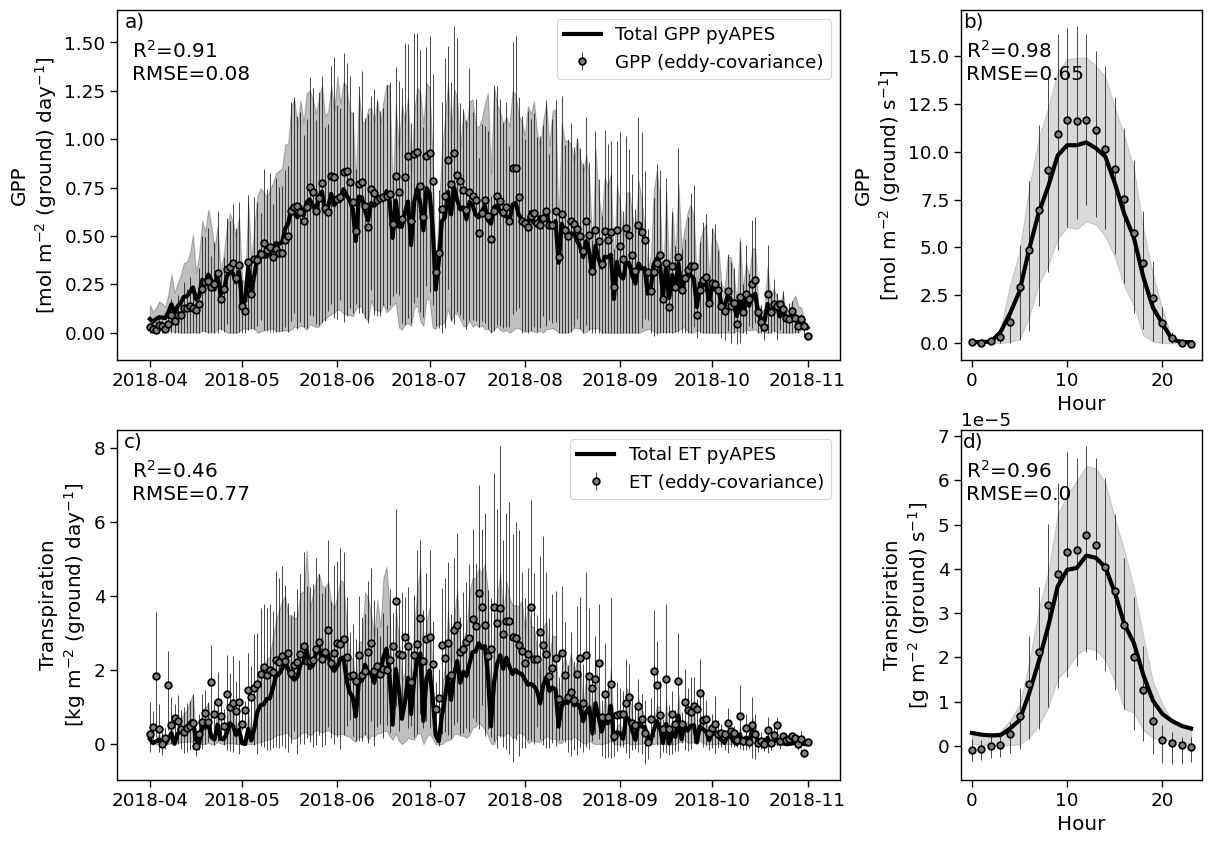

In [30]:
# Figure settings
fig, axs = plt.subplots(figsize=(14,10), nrows=2, ncols=2, width_ratios=[3,1])
axs = axs.flatten()
fig.subplots_adjust(wspace=0.25)
planttypes = list(simdata.canopy_planttypes.data)

# # Individual plant types GPP
# for i,pt in enumerate(planttypes):
#     #axs[0].fill_between(pt_total_gpp_daily.date, pt_total_gpp_daily_lb[:, 0, i], pt_total_gpp_daily_ub[:, 0, i], alpha=0.25)
#     axs[0].plot(pt_total_gpp_daily_mean.date, pt_total_gpp_daily_mean[:, 0, i], label=f'GPP {pt} pyAPES')

#Total pyAPES GPP
axs[0].fill_between(pt_total_gpp_daily_mean_sum.date, pt_total_gpp_daily_lb_sum[:, 0], pt_total_gpp_daily_ub_sum[:, 0], color='k', alpha=0.25)
axs[0].plot(pt_total_gpp_daily_mean_sum.date, pt_total_gpp_daily_mean_sum, color='k', label=r'Total GPP pyAPES', linewidth=3)

# EC GPP
axs[0].errorbar(flx_gpp_daily.index, flx_gpp_daily, yerr = flx_gpp_daily_error, fmt='ko', elinewidth=0.5, 
                markerfacecolor='grey', markeredgewidth=1.25, label='GPP (eddy-covariance)')

#Diurnal planttypes GPP
# gpp_diurnal_pt = [gpp_diurnal_decid, gpp_diurnal_pine, gpp_diurnal_shrubs, gpp_diurnal_spruce]
# for i, gpp_pt in enumerate(gpp_diurnal_pt):
#     axs[1].plot(gpp_pt['hour'], gpp_pt['mean'])


#Diurnal pyAPES GPP
axs[1].fill_between(gpp_diurnal['hour'], gpp_diurnal_lb, gpp_diurnal_ub, alpha=0.15, color='k')
axs[1].plot(gpp_diurnal['hour'], gpp_diurnal_mean, color='k', linewidth=3)

# Diurnal EC GPP
axs[1].errorbar(flx_gpp_diurnal.hour, flx_gpp_diurnal_mean, yerr = flx_gpp_diurnal_error, fmt='ko', elinewidth=0.5, 
                markerfacecolor='grey', markeredgewidth=1.25, label='GPP (eddy-covariance)')

# R2&RMSE texts for GPP

## GPP timeseries
r2_gpp_ts = r2_score(flx_gpp_daily, pt_total_gpp_daily_mean_sum)
rmse_gpp_ts = np.sqrt(np.mean((flx_gpp_daily.values - pt_total_gpp_daily_mean_sum[:, 0].values)**2.0))
axs[0].text(0.02, 0.8, f'R$^{{2}}$={np.round(r2_gpp_ts,2)}\nRMSE={np.round(rmse_gpp_ts,2)}', transform=axs[0].transAxes)

## GPP diurnal cycle
r2_gpp_diurnal = r2_score(flx_gpp_diurnal_mean, gpp_diurnal_mean)
rmse_gpp_diurnal = np.sqrt(np.mean((flx_gpp_diurnal_mean.values - gpp_diurnal_mean)**2.0))
axs[1].text(0.02, 0.8, f'R$^{{2}}$={np.round(r2_gpp_diurnal,2)}\nRMSE={np.round(rmse_gpp_diurnal,2)}', transform=axs[1].transAxes) 

# #Individual pt transpiration

# for i,pt in enumerate(planttypes):
#     #axs[0].fill_between(pt_total_gpp_daily.date, pt_total_gpp_daily_lb[:, 0, i], pt_total_gpp_daily_ub[:, 0, i], alpha=0.25)
#     axs[2].plot(pt_total_transpiration_daily_mean.date, pt_total_transpiration_daily_mean[:, 0, i], label=f'Tr. {pt} pyAPES')

# Forest floor and canopy evaporation

# axs[2].plot(canopy_evaporation_daily_mean.date, canopy_evaporation_daily_mean, label='Evap. canopy')
# axs[2].plot(forest_floor_evaporation_daily_mean.date, forest_floor_evaporation_daily_mean, label='Evap. forest floor')

#Total pyAPES transpiration

axs[2].fill_between(total_evapotranspiration_daily_mean_sum.date, total_evapotranspiration_daily_lb_sum[:, 0], total_evapotranspiration_daily_ub_sum[:, 0], color='k', alpha=0.25)
axs[2].plot(total_evapotranspiration_daily_mean_sum.date, total_evapotranspiration_daily_mean_sum, color='k', label=r'Total ET pyAPES', linewidth=3)

#EC ET

axs[2].errorbar(flx_ET_daily.index, flx_ET_daily, yerr = flx_ET_daily_error, fmt='ko', elinewidth=0.5, 
                markerfacecolor='grey', markeredgewidth=1.25, label='ET (eddy-covariance)')

# #Diurnal planttype transpiration
# transpiration_diurnal_pt = [transpiration_diurnal_decid, transpiration_diurnal_pine, transpiration_diurnal_shrubs, transpiration_diurnal_spruce]
# for i, transpiration_pt in enumerate(transpiration_diurnal_pt):
#     axs[3].plot(transpiration_pt['hour'], transpiration_pt['mean'])

#Diurnal pyAPES Transpiration

axs[3].fill_between(ET_diurnal['hour'], ET_diurnal_lb, ET_diurnal_ub, alpha=0.15, color='k')
axs[3].plot(ET_diurnal['hour'], ET_diurnal_mean, color='k', linewidth=3)

#Diurnal EC ET

axs[3].errorbar(flx_ET_diurnal.hour, flx_ET_diurnal_mean, yerr = flx_ET_diurnal_error, fmt='ko', elinewidth=0.5, 
                markerfacecolor='grey', markeredgewidth=1.25)

# R2&RMSE texts for ET

## ET timeseries
r2_gpp_ts = r2_score(flx_ET_daily, total_evapotranspiration_daily_mean_sum)
rmse_gpp_ts = np.sqrt(np.mean((flx_ET_daily.values - total_evapotranspiration_daily_mean_sum[:, 0].values)**2.0))
axs[2].text(0.02, 0.8, f'R$^{{2}}$={np.round(r2_gpp_ts,2)}\nRMSE={np.round(rmse_gpp_ts,2)}', transform=axs[2].transAxes)

## ET diurnal cycle
r2_gpp_diurnal = r2_score(flx_ET_diurnal_mean, ET_diurnal_mean)
rmse_gpp_diurnal = np.sqrt(np.mean((flx_ET_diurnal_mean.values - ET_diurnal_mean)**2.0))
axs[3].text(0.02, 0.8, f'R$^{{2}}$={np.round(r2_gpp_diurnal,2)}\nRMSE={np.round(rmse_gpp_diurnal,2)}', transform=axs[3].transAxes) 

#Legend and labels
axs[0].legend()
axs[2].legend()

axs[0].set_ylabel('GPP\n[mol m$^{-2}$ (ground) day$^{-1}$]')

axs[1].set_xlabel('Hour')

axs[1].set_ylabel('GPP\n[mol m$^{-2}$ (ground) s$^{-1}$]')

axs[2].set_ylabel('Transpiration\n[kg m$^{-2}$ (ground) day$^{-1}$]')

axs[3].set_xlabel('Hour')

axs[3].set_ylabel('Transpiration\n[g m$^{-2}$ (ground) s$^{-1}$]')

axs[0].text(0.01, 0.95, 'a)', transform=axs[0].transAxes)

axs[1].text(0.01, 0.95, 'b)', transform=axs[1].transAxes)

axs[2].text(0.01, 0.95, 'c)', transform=axs[2].transAxes)

axs[3].text(0.01, 0.95, 'd)', transform=axs[3].transAxes)

### Figure: no rain

<>:121: SyntaxWarning: invalid escape sequence '\m'
<>:121: SyntaxWarning: invalid escape sequence '\m'
/var/folders/_7/7fgf24sd5ggbyr5x9kzrwz7c0000gn/T/ipykernel_2130/3363269892.py:121: SyntaxWarning: invalid escape sequence '\m'
  axs[3].set_ylabel('Transpiration\n[$\mu$g m$^{-2}$ (ground) s$^{-1}$]')


Text(0.01, 0.95, 'd)')

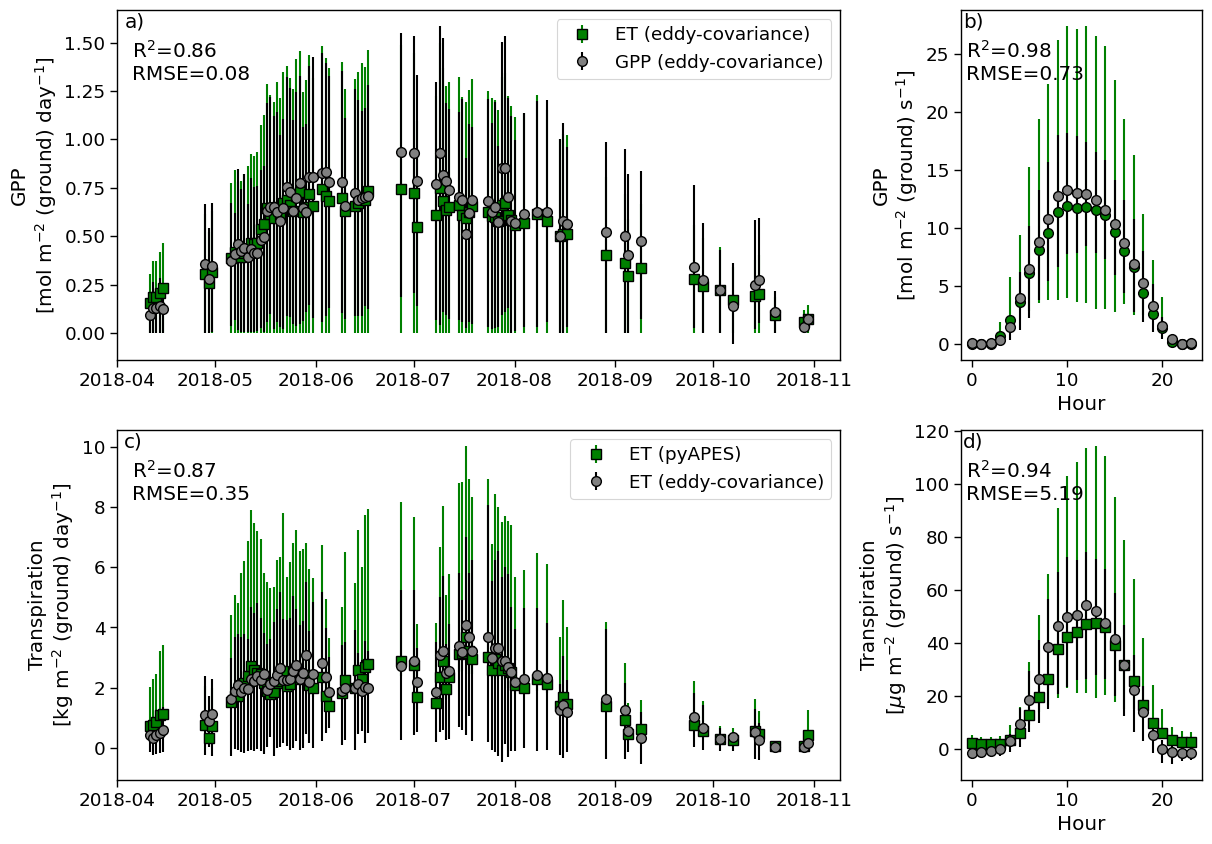

In [51]:
# Figure settings
fig, axs = plt.subplots(figsize=(14,10), nrows=2, ncols=2, width_ratios=[3,1])
axs = axs.flatten()
fig.subplots_adjust(wspace=0.25)
planttypes = list(simdata.canopy_planttypes.data)

# # Individual plant types GPP
# for i,pt in enumerate(planttypes):
#     #axs[0].fill_between(pt_total_gpp_daily.date, pt_total_gpp_daily_lb[:, 0, i], pt_total_gpp_daily_ub[:, 0, i], alpha=0.25)
#     axs[0].plot(pt_total_gpp_daily_mean.date, pt_total_gpp_daily_mean[:, 0, i], label=f'GPP {pt} pyAPES')

#Total pyAPES GPP
# axs[0].fill_between(pt_total_gpp_daily_mean_sum_nr.date, pt_total_gpp_daily_lb_sum_nr[:, 0], pt_total_gpp_daily_ub_sum_nr[:, 0], color='k', alpha=0.25)
# axs[0].plot(pt_total_gpp_daily_mean_sum_nr.date, pt_total_gpp_daily_mean_sum_nr, color='k', label=r'Total GPP pyAPES', linewidth=3)

axs[0].errorbar((pt_total_gpp_daily_mean_sum_nr.date).values, pt_total_gpp_daily_mean_sum_nr[:, 0],
                yerr = np.abs(np.vstack((pt_total_gpp_daily_mean_sum_nr[:, 0],pt_total_gpp_daily_mean_sum_nr[:, 0]))), 
                fmt='ks', markersize=7, elinewidth=1.5, markerfacecolor='green', markeredgewidth=1, label='ET (eddy-covariance)', ecolor='green')

# EC GPP
axs[0].errorbar(flx_gpp_daily_nr.index, flx_gpp_daily_nr, yerr = flx_gpp_daily_error_nr, fmt='ko', elinewidth=1.5, 
                markersize=7, markerfacecolor='grey', markeredgewidth=1, label='GPP (eddy-covariance)')

#Diurnal planttypes GPP
# gpp_diurnal_pt = [gpp_diurnal_decid, gpp_diurnal_pine, gpp_diurnal_shrubs, gpp_diurnal_spruce]
# for i, gpp_pt in enumerate(gpp_diurnal_pt):
#     axs[1].plot(gpp_pt['hour'], gpp_pt['mean'])


#Diurnal pyAPES GPP
# axs[1].fill_between(gpp_diurnal_nr['hour'], gpp_diurnal_lb_nr, gpp_diurnal_ub_nr, alpha=0.15, color='k')
# axs[1].plot(gpp_diurnal_nr['hour'], gpp_diurnal_mean_nr, color='k', linewidth=3)

axs[1].errorbar(gpp_diurnal_nr['hour'], gpp_diurnal_mean_nr, yerr = np.abs(np.vstack((gpp_diurnal_lb_nr, gpp_diurnal_ub_nr))), fmt='ko', elinewidth=1.5, 
                markersize=7, markerfacecolor='green', markeredgewidth=1, ecolor='green', label='GPP (pyAPES)')

# Diurnal EC GPP
axs[1].errorbar(flx_gpp_diurnal.hour, flx_gpp_diurnal_mean_nr, yerr = flx_gpp_diurnal_error, fmt='ko', elinewidth=1.5, 
                markersize=7, markerfacecolor='grey', markeredgewidth=1, label='GPP (eddy-covariance)')

# R2&RMSE texts for GPP

## GPP timeseries
r2_gpp_ts = r2_score(flx_gpp_daily_nr, pt_total_gpp_daily_mean_sum_nr)
rmse_gpp_ts = np.sqrt(np.mean((flx_gpp_daily_nr.values - pt_total_gpp_daily_mean_sum_nr[:, 0].values)**2.0))
axs[0].text(0.02, 0.8, f'R$^{{2}}$={np.round(r2_gpp_ts,2)}\nRMSE={np.round(rmse_gpp_ts,2)}', transform=axs[0].transAxes)

## GPP diurnal cycle
r2_gpp_diurnal = r2_score(flx_gpp_diurnal_mean_nr, gpp_diurnal_mean_nr)
rmse_gpp_diurnal = np.sqrt(np.mean((flx_gpp_diurnal_mean_nr.values - gpp_diurnal_mean_nr)**2.0))
axs[1].text(0.02, 0.8, f'R$^{{2}}$={np.round(r2_gpp_diurnal,2)}\nRMSE={np.round(rmse_gpp_diurnal,2)}', transform=axs[1].transAxes) 

# #Individual pt transpiration

# for i,pt in enumerate(planttypes):
#     #axs[0].fill_between(pt_total_gpp_daily.date, pt_total_gpp_daily_lb[:, 0, i], pt_total_gpp_daily_ub[:, 0, i], alpha=0.25)
#     axs[2].plot(pt_total_transpiration_daily_mean.date, pt_total_transpiration_daily_mean[:, 0, i], label=f'Tr. {pt} pyAPES')

# Forest floor and canopy evaporation

# axs[2].plot(canopy_evaporation_daily_mean.date, canopy_evaporation_daily_mean, label='Evap. canopy')
# axs[2].plot(forest_floor_evaporation_daily_mean.date, forest_floor_evaporation_daily_mean, label='Evap. forest floor')

#Total pyAPES transpiration

# axs[2].fill_between(total_evapotranspiration_daily_mean_sum_nr.date, total_evapotranspiration_daily_lb_sum_nr[:, 0], total_evapotranspiration_daily_ub_sum_nr[:, 0], color='k', alpha=0.25)
# axs[2].plot(total_evapotranspiration_daily_mean_sum_nr.date, total_evapotranspiration_daily_mean_sum_nr, color='k', label=r'Total ET pyAPES', linewidth=3)

axs[2].errorbar((total_evapotranspiration_daily_mean_sum_nr.date).values, total_evapotranspiration_daily_mean_sum_nr[:, 0],
                yerr = np.abs(np.vstack((total_evapotranspiration_daily_lb_sum_nr[:, 0],total_evapotranspiration_daily_ub_sum_nr[:, 0]))), 
                fmt='ks', markersize=7, elinewidth=1.5, markerfacecolor='green', markeredgewidth=1, label='ET (pyAPES)', ecolor='green')

#EC ET

axs[2].errorbar(flx_ET_daily_nr.index, flx_ET_daily_nr, yerr = flx_ET_daily_error_nr, fmt='ko', elinewidth=1.5, 
                markersize=7, markerfacecolor='grey', markeredgewidth=1, label='ET (eddy-covariance)')

# #Diurnal planttype transpiration
# transpiration_diurnal_pt = [transpiration_diurnal_decid, transpiration_diurnal_pine, transpiration_diurnal_shrubs, transpiration_diurnal_spruce]
# for i, transpiration_pt in enumerate(transpiration_diurnal_pt):
#     axs[3].plot(transpiration_pt['hour'], transpiration_pt['mean'])

#Diurnal pyAPES Transpiration

# axs[3].fill_between(ET_diurnal_nr['hour'], ET_diurnal_lb_nr, ET_diurnal_ub_nr, alpha=0.15, color='k')
# axs[3].plot(ET_diurnal_nr['hour'], ET_diurnal_mean_nr, color='k', linewidth=3)
axs[3].errorbar(ET_diurnal_nr['hour'], ET_diurnal_mean_nr*1e6, yerr = np.abs(np.vstack((ET_diurnal_lb_nr, ET_diurnal_ub_nr)))*1e6, fmt='ks', elinewidth=1.5, 
                markersize=7, markerfacecolor='green', markeredgewidth=1, ecolor='green')

#Diurnal EC ET

axs[3].errorbar(flx_ET_diurnal_nr.hour, flx_ET_diurnal_mean_nr*1e6, yerr = flx_ET_diurnal_error_nr*1e6, fmt='ko', elinewidth=1.5, 
                markersize=7, markerfacecolor='grey', markeredgewidth=1)

# R2&RMSE texts for ET

## ET timeseries
r2_gpp_ts = r2_score(flx_ET_daily_nr, total_evapotranspiration_daily_mean_sum_nr)
rmse_gpp_ts = np.sqrt(np.mean((flx_ET_daily_nr.values - total_evapotranspiration_daily_mean_sum_nr[:, 0].values)**2.0))
axs[2].text(0.02, 0.8, f'R$^{{2}}$={np.round(r2_gpp_ts,2)}\nRMSE={np.round(rmse_gpp_ts,2)}', transform=axs[2].transAxes)

## ET diurnal cycle
r2_ET_diurnal = r2_score(flx_ET_diurnal_mean_nr, ET_diurnal_mean_nr)
rmse_ET_diurnal = np.sqrt(np.mean((flx_ET_diurnal_mean_nr.values*1e6 - ET_diurnal_mean_nr*1e6)**2.0))
axs[3].text(0.02, 0.8, f'R$^{{2}}$={np.round(r2_ET_diurnal,2)}\nRMSE={np.round(rmse_ET_diurnal,2)}', transform=axs[3].transAxes) 

#Legend and labels
axs[0].legend()
axs[2].legend()

axs[0].set_ylabel('GPP\n[mol m$^{-2}$ (ground) day$^{-1}$]')

axs[1].set_xlabel('Hour')

axs[1].set_ylabel('GPP\n[mol m$^{-2}$ (ground) s$^{-1}$]')

axs[2].set_ylabel('Transpiration\n[kg m$^{-2}$ (ground) day$^{-1}$]')

axs[3].set_xlabel('Hour')

axs[3].set_ylabel('Transpiration\n[$\mu$g m$^{-2}$ (ground) s$^{-1}$]')

axs[0].text(0.01, 0.95, 'a)', transform=axs[0].transAxes)

axs[1].text(0.01, 0.95, 'b)', transform=axs[1].transAxes)

axs[2].text(0.01, 0.95, 'c)', transform=axs[2].transAxes)

axs[3].text(0.01, 0.95, 'd)', transform=axs[3].transAxes)

In [32]:
def summarize_data_variable(data, column_names, z, simulation, planttype=None):

    df = pd.DataFrame(index=z, columns=column_names)
    
    if planttype is not None:
        data_selected = data.sel(simulation=simulation, planttype=planttype)
    else:
        data_selected = data.sel(simulation=simulation)
    # Check that there dims are now ('date','canopy')
    if not data_selected.dims==('date','canopy'):
        print('After selection data dimensions are not (date, canopy). Please check simulation number and planttype number')
        return pd.DataFrame()

    for col in column_names:
        if col == 'median':
            df[col] = data_selected.median(dim='date')
        elif col == 'mean':
            df[col] = data_selected.mean(dim='date')
        else:
            # calculate percentiles
            percentile = int(re.findall(r'\d+', col)[0])
            df[col] = data_selected.quantile(percentile/100, dim='date')
    return df


In [33]:
percentiles = [5, 25, 75, 95]
vars = ['pt_net_co2','pt_leaf_temperature','canopy_wind_speed']
#vars = ['canopy_wind_speed']
res = {}
df_columns = ['mean', 'median'] + [f'{i}th' for i in percentiles]

hour_start = 10
hour_end = 14
month_start = 5
month_end = 9

time_mask = ((simdata.date.dt.month >= month_start) & (simdata.date.dt.month <= month_end) & (
    simdata.date.dt.hour >= hour_start) & (simdata.date.dt.hour <= hour_end))

data_time_mask = simdata.sel(date=time_mask)
for i, var in enumerate(vars):
    if 'canopy' not in data_time_mask[var].dims:
        print(f'Canopy not in {var} dimensions')
        print('Omitting')
        continue
    if 'planttype' in data_time_mask[var].dims:
        num_planttypes = len(data_time_mask.canopy_planttypes)
    else:
        num_planttypes = 0
    if 'simulation' in data_time_mask[var].dims:
        num_simulations = len(data_time_mask.simulation)
    else:
        num_simulations = 1

    if num_planttypes == 0 and num_simulations < 2:
        # No need to loop over planttypes
        # Only one simulation, no need to loop over simulations
        res_key = f'{var}'
        res[res_key] = summarize_data_variable(data_time_mask[var],df_columns, data_time_mask.canopy_z, 0)
    elif num_planttypes > 0 and num_simulations < 2:
        # Loop over planttypes but do not loop over simulations
        for pt_ind,pt in enumerate(data_time_mask.canopy_planttypes.values):
            res_key = f'{var}_{pt}'
            res[res_key] = summarize_data_variable(data_time_mask[var],df_columns, data_time_mask.canopy_z, 0, pt_ind)

    elif num_planttypes == 0 and num_simulations >= 1:
        # Loop over simulations but no need to loop over planttypes
        for sim_ind in simdata.simulation.values:
            res_key = f'{var}_{sim_ind}'
            res[res_key] = summarize_data_variable(data_time_mask[var],df_columns, data_time_mask.canopy_z, sim_ind)

    elif num_planttypes > 0 and num_simulations >= 1:
        # Loop over simulations and planttypes
        for i in simdata.simulation.values:
            for pt_ind,pt in enumerate(data_time_mask.canopy_planttypes.values):
                res_key = f'{var}_{pt}_{i}'
                res[res_key] = summarize_data_variable(data_time_mask[var],df_columns, data_time_mask.canopy_z, sim_ind, pt_ind)

/Users/opa/pyAPES_main/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/Users/opa/pyAPES_main/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/Users/opa/pyAPES_main/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/Users/opa/pyAPES_main/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


## Vertical profiles for selected variables

In [34]:
def vertical_canopy_profile(data:xr.Dataset, month_start=1, month_end=12, hour_start:int=0, hour_end:int=23):
    """Computes vertical profile of environmental data

    Args:
        data (xr.Dataset): environmental data where index = pd.datetime, i.e. '1996-01-01 00:30:00'
        hour_start (int, optional): _description_. Defaults to 0.
        hour_end (int, optional): _description_. Defaults to 23.

    Returns:
        dict: keys == data.columns
                    values == pd.dataframe where
                                columns = ['hour', 'minu', 'N', 'mean', 'std', 'se',
                                           'median', '5th', '25th', '75th', '95th'
                                          ]
    """    

    percentiles = [5, 25, 75, 95]
    vars = ['pt_net_co2','pt_leaf_temperature','canopy_wind_speed']
    #vars = ['canopy_wind_speed']
    res = {}
    df_columns = ['mean', 'median'] + [f'{i}th' for i in percentiles]

    hour_start = 10
    hour_end = 14
    month_start = 5
    month_end = 9

    time_mask = ((simdata.date.dt.month >= month_start) & (simdata.date.dt.month <= month_end) & (
        simdata.date.dt.hour >= hour_start) & (simdata.date.dt.hour <= hour_end))

    data_time_mask = simdata.sel(date=time_mask)
    for i, var in enumerate(vars):
        if 'canopy' not in data_time_mask[var].dims:
            print(f'Canopy not in {var} dimensions')
            print('Omitting')
            continue
        if 'planttype' in data_time_mask[var].dims:
            num_planttypes = len(data_time_mask.canopy_planttypes)
        else:
            num_planttypes = 0
        if 'simulation' in data_time_mask[var].dims:
            num_simulations = len(data_time_mask.simulation)
        else:
            num_simulations = 1

        if num_planttypes == 0 and num_simulations < 2:
            # No need to loop over planttypes
            # Only one simulation, no need to loop over simulations
            res_key = f'{var}'
            res[res_key] = summarize_data_variable(data_time_mask[var],df_columns, data_time_mask.canopy_z, 0)
        elif num_planttypes > 0 and num_simulations < 2:
            # Loop over planttypes but do not loop over simulations
            for pt_ind,pt in enumerate(data_time_mask.canopy_planttypes.values):
                res_key = f'{var}_{pt}'
                res[res_key] = summarize_data_variable(data_time_mask[var],df_columns, data_time_mask.canopy_z, 0, pt_ind)

        elif num_planttypes == 0 and num_simulations >= 1:
            # Loop over simulations but no need to loop over planttypes
            for sim_ind in simdata.simulation.values:
                res_key = f'{var}_{sim_ind}'
                res[res_key] = summarize_data_variable(data_time_mask[var],df_columns, data_time_mask.canopy_z, sim_ind)

        elif num_planttypes > 0 and num_simulations >= 1:
            # Loop over simulations and planttypes
            for i in simdata.simulation.values:
                for pt_ind,pt in enumerate(data_time_mask.canopy_planttypes.values):
                    res_key = f'{var}_{pt}_{i}'
                    res[res_key] = summarize_data_variable(data_time_mask[var],df_columns, data_time_mask.canopy_z, sim_ind, pt_ind)

    return res

## Vertical profiles for selected variables

In [52]:
simdata

<xarray.Dataset> Size: 507MB
Dimensions:                               (date: 10273, simulation: 1,
                                           canopy: 101, planttype: 4, soil: 1,
                                           groundtype: 1)
Coordinates:
  * date                                  (date) datetime64[ns] 82kB 2018-04-...
Dimensions without coordinates: simulation, canopy, planttype, soil, groundtype
Data variables: (12/157)
    forcing_air_temperature               (date, simulation) float32 41kB ...
    forcing_precipitation                 (date, simulation) float32 41kB 0.0...
    forcing_pressure                      (date, simulation) float32 41kB ...
    forcing_h2o                           (date, simulation) float32 41kB ...
    forcing_co2                           (date, simulation) float32 41kB ...
    forcing_wind_speed                    (date, simulation) float32 41kB ...
    ...                                    ...
    gt_water_content                      (date, simulation, groundtype) float32 41kB ...
    gt_volumetric_water                   (date, simulation, groundtype) float32 41kB ...
    gt_water_storage                      (date, simulation, groundtype) float32 41kB ...
    gt_water_potential                    (date, simulation, groundtype) float32 41kB ...
    gt_hydraulic_conductivity             (date, simulation, groundtype) float32 41kB ...
    gt_thermal_conductivity               (date, simulation, groundtype) float32 41kB ...
Attributes:
    description:  pyAPES_MLM results
    history:      created 2025-10-23 11:14:55
    source:       pyAPES_beta2018

### Add new incident par radiation variable to results

In [53]:
simdata['canopy_absorbed_par'] = simdata['canopy_par_absorbed_sunlit']*simdata['canopy_sunlit_fraction'] + simdata['canopy_par_absorbed_shaded']*(1-simdata['canopy_sunlit_fraction'])

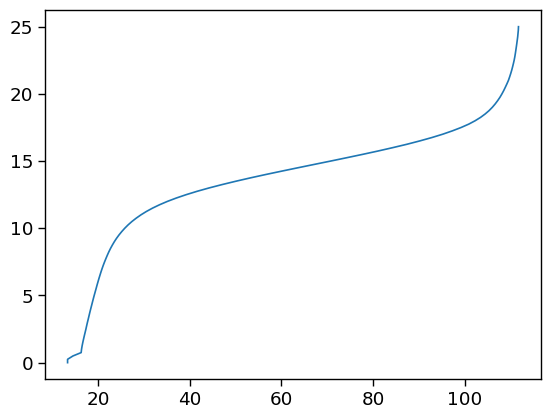

In [68]:
fig, ax = plt.subplots()
date_target = '201806011200'
ind_date = np.argmax(simdata.date.values > pd.to_datetime('201806011200'))
ax.plot(simdata['canopy_absorbed_par'][ind_date, 0, :], simdata['canopy_z'])

In [ ]:
variables = ['canopy_wind_speed','pt_leaf_temperature','pt_net_co2','canopy_absorber_par', ]

## GPP for individual levels per plant type

In [35]:
pt_net_co2_daily = simdata.pt_net_co2.resample(date='D').mean()

In [36]:
species_ind = [i for i, name in enumerate(simdata.canopy_planttypes.data) if name in ['decid','pine','spruce']]

In [37]:
5*0.25

1.25

In [38]:
# find 25% & 75% crown height from maximum crown height for spruce, decid, pine
lad_ind = [2, 0, 1] # lad index are pine, spruce, decid so 2,0,1 is ['decid','pine','spruce']

crown_height_25th_ind = []
crown_height_75th_ind = []
for i in lad_ind:
    if i==1:
        #For spruce neglect the understory around 5m
        max_ind = np.argmax(lad[20:, i])+20
    else:
        max_ind = np.argmax(lad[:,i])
    crown_min = int(max_ind*0.25)
    crown_height_25th_ind.append(int(max_ind))


NameError: name 'lad' is not defined

In [ ]:
pt_net_co2_daily

<xarray.DataArray 'pt_net_co2' (date: 215, simulation: 1, planttype: 4,
                                canopy: 101)> Size: 347kB
array([[[[ 0.00000000e+00,  0.00000000e+00,  2.98638715e-05, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  1.01947001e-06, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  1.57586798e-01,  1.58410162e-01, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  2.54329969e-03, ...,
           8.95679230e-04,  4.13836766e-04,  0.00000000e+00]]],


       [[[ 0.00000000e+00,  0.00000000e+00,  2.84786165e-05, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  7.95663482e-07, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  1.19158469e-01,  1.19607665e-01, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  1.98826892e-03, ...,
           8.86883121e-04,  4.12053545e-04,  0.00000000e+00]]],


...

       [[[ 0.00000000e+00,  0.00000000e+00,  1.21169141e-05, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00, -6.00344734e-08, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -3.40389386e-02, -2.82802284e-02, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  3.96662035e-05, ...,
           2.64783204e-03,  1.24549260e-03,  0.00000000e+00]]],


       [[[ 0.00000000e+00,  0.00000000e+00, -6.05835066e-06, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00, -1.79213785e-07, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -6.93837032e-02, -6.50821999e-02, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00, -5.88619674e-04, ...,
           4.49911226e-04,  2.10874146e-04,  0.00000000e+00]]]],
      shape=(215, 1, 4, 101), dtype=float32)
Coordinates:
  * date     (date) datetime64[ns] 2kB 2018-04-01 2018-04-02 ... 2018-11-01
Dimensions without coordinates: simulation, planttype, canopy
Attributes:
    units:    net co2 uptake [umol m-3 s-1]

In [ ]:
species_ind

[0, 1, 3]

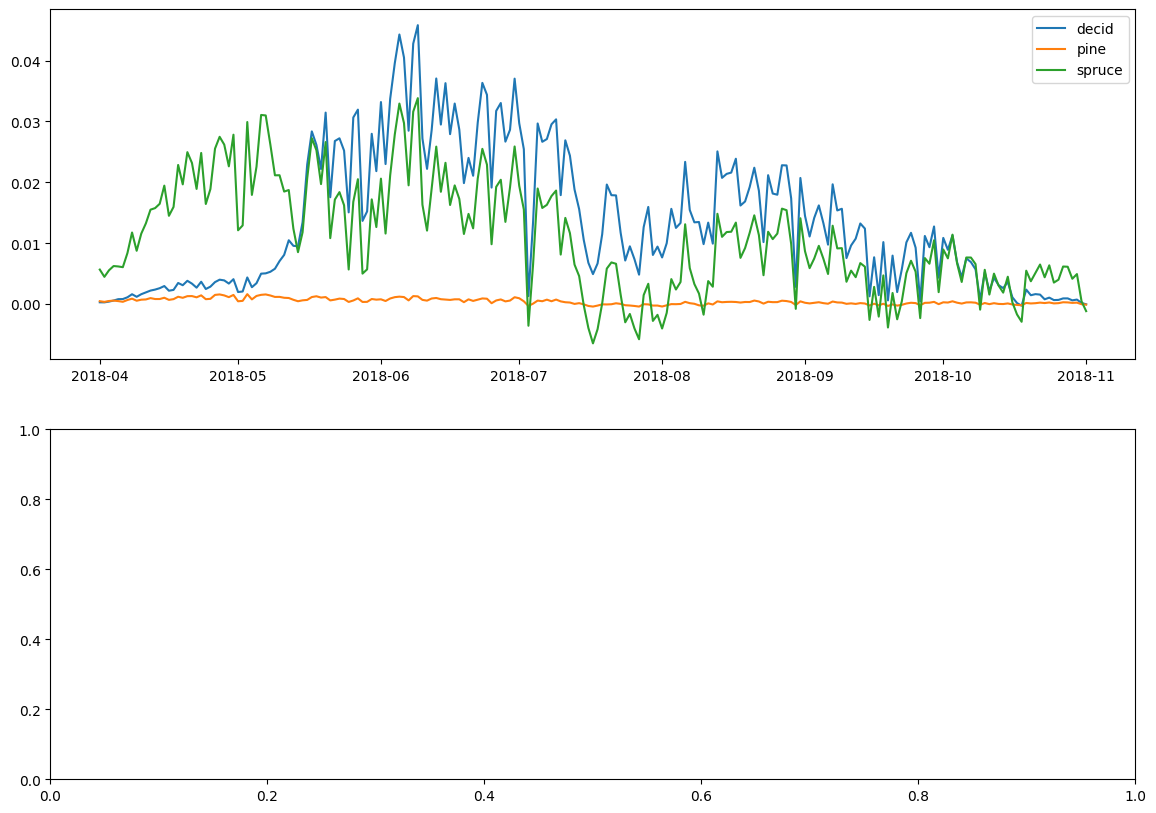

In [ ]:
fig, axs = plt.subplots(figsize=(14,10), nrows=2)
lines = []
for height_ind, spec_ind in enumerate(species_ind):
    axs[0].plot(pt_net_co2_daily.date, pt_net_co2_daily[:, 0, spec_ind, crown_height_25th_ind[height_ind]], label=list(simdata.canopy_planttypes[species_ind].values)[height_ind])

axs[0].legend()